# Classifica√ß√£o de textos do Twitter com spaCy

# Importa√ß√£o e instala√ß√£o das bibliotecas

In [12]:
!pip install spacy --upgrade

In [ ]:
import spacy
spacy.__version__

'3.8.7'

In [ ]:
!python -m spacy download pt_core_news_sm

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13.0/13.0 MB 129.5 MB/s eta 0:00:00
‚úî Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
‚ö† Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
import pandas as pd
import string
import spacy
import en_core_web_sm
import random
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Carregamento das bases de dados

- Link Kaggle: https://www.kaggle.com/augustop/portuguese-tweets-for-sentiment-analysis#TweetsNeutralHash.csv

## Base de treinamento

Valores da Coluna sentiment  
Negative label: 0  
Positive label: 1  

In [24]:

# url do reposit√≥rio
url = (r'https://raw.githubusercontent.com/jgfilho/Classifica-o_Textos_do_Twitter_com_spaCy_IA/main/data/Train50.csv')

base_treinamento = pd.read_csv(url, delimiter=';', on_bad_lines='skip')

In [25]:
base_treinamento.shape

(50000, 5)

In [26]:
base_treinamento.head()

id                                         tweet_text  \
0  1050785521201541121  @Laranjito76 A pessoa certa para isso seria o ...   
1  1050785431955140608  @behin_d_curtain Para mim, √© precisamente o co...   
2  1050785401248645120  Vou fazer um video hoje... estou pensando em f...   
3  1050785370982547461  aaaaaaaa amei tanto essas polaroids, nem sei e...   
4  1050785368902131713  Valoriza o cora√ß√£o do menininho que vc tem. El...   

                       tweet_date  sentiment query_used  
0  Fri Oct 12 16:29:25 +0000 2018          1         :)  
1  Fri Oct 12 16:29:04 +0000 2018          1         :)  
2  Fri Oct 12 16:28:56 +0000 2018          1         :)  
3  Fri Oct 12 16:28:49 +0000 2018          1         :)  
4  Fri Oct 12 16:28:49 +0000 2018          1         :)

<ipython-input-27-6ee3df71da3a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


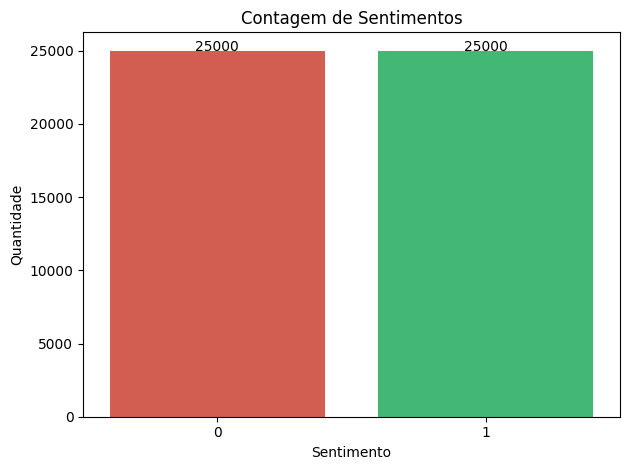

In [27]:
# Contagem (√∫til p/ ordenar e anotar)
contagem = base_treinamento['sentiment'].value_counts()

# Cores para cada r√≥tulo
cores = {0: '#e74c3c',   # vermelho p/ 0
         1: '#2ecc71'}   # verde    p/ 1

# Ordem fixa (0 primeiro, 1 depois) ‚Äî mude se quiser outra ordem
ordem = [0, 1]

ax = sns.countplot(
    data=base_treinamento,
    x='sentiment',
    order=ordem,
    palette=[cores[r] for r in ordem]      # aplica a cor certa a cada r√≥tulo
)

ax.set_title('Contagem de Sentimentos')
ax.set_xlabel('Sentimento')
ax.set_ylabel('Quantidade')

# R√≥tulos de contagem ‚Äî agora convertendo para int
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='baseline', fontsize=10
    )

plt.tight_layout()

plt.show()

In [ ]:
base_treinamento.drop(['id', 'tweet_date', 'query_used'], axis = 1, inplace=True)

In [ ]:
base_treinamento.head()

tweet_text  sentiment
0  @Laranjito76 A pessoa certa para isso seria o ...          1
1  @behin_d_curtain Para mim, √© precisamente o co...          1
2  Vou fazer um video hoje... estou pensando em f...          1
3  aaaaaaaa amei tanto essas polaroids, nem sei e...          1
4  Valoriza o cora√ß√£o do menininho que vc tem. El...          1

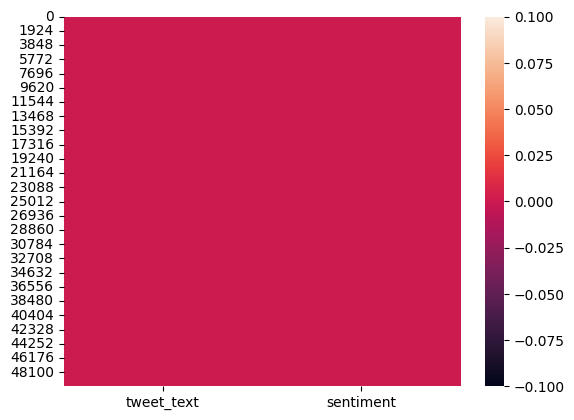

In [ ]:
#veriricar a existencia de dados ausentes.

sns.heatmap(pd.isnull(base_treinamento));

## Base de teste

In [20]:
url_test = (r'https://raw.githubusercontent.com/jgfilho/Classifica-o_Textos_do_Twitter_com_spaCy_IA/main/data/Test.csv')

base_teste = pd.read_csv(url_test, delimiter=';', on_bad_lines='skip')

In [22]:
base_teste.shape

(5000, 5)

In [21]:
base_teste.head()

id                                         tweet_text  \
0  1029536486021099522                   @Gazo1a Nossa! Muito obrigada :)   
1  1029536496368406528             @BerzGamer vai pa puta que te pariu :)   
2  1029536531655131137  QUER MAIS DESCONTOS? (14/08) ‚≠ê‚≠ê‚≠ê‚≠ê‚≠ê üåê Confira n...   
3  1029536560117678081  EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...   
4  1029536605852377088  Est√°vamos em casa do Z√© e eu estava a morrer d...   

                       tweet_date  sentiment query_used  
0  Wed Aug 15 01:13:20 +0000 2018          1         :)  
1  Wed Aug 15 01:13:23 +0000 2018          1         :)  
2  Wed Aug 15 01:13:31 +0000 2018          1         :)  
3  Wed Aug 15 01:13:38 +0000 2018          1         :)  
4  Wed Aug 15 01:13:49 +0000 2018          1         :)

In [23]:
base_teste.drop(['id', 'tweet_date', 'query_used'], axis = 1, inplace=True)

In [ ]:
base_teste.head()

tweet_text  sentiment
0                   @Gazo1a Nossa! Muito obrigada :)          1
1             @BerzGamer vai pa puta que te pariu :)          1
2  QUER MAIS DESCONTOS? (14/08) ‚≠ê‚≠ê‚≠ê‚≠ê‚≠ê üåê Confira n...          1
3  EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...          1
4  Est√°vamos em casa do Z√© e eu estava a morrer d...          1

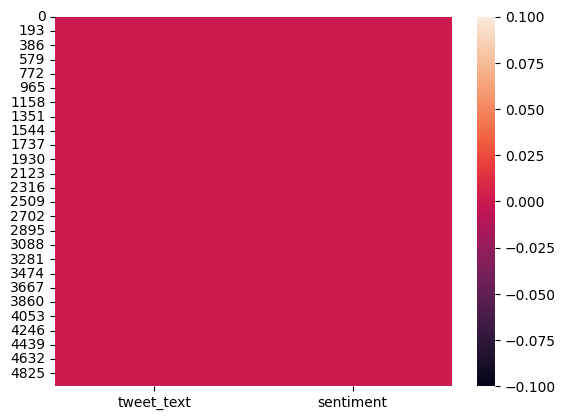

In [ ]:
#veriricar a existencia de dados ausentes.

sns.heatmap(pd.isnull(base_teste));

# Fun√ß√£o para pr√©-processamento dos textos

- Letras min√∫sculas
- Nome do usu√°rio (@)
- URLs
- Espa√ßos em branco
- Emoticons
- Stop words
- Lematiza√ß√£o
- Pontua√ß√µes

In [ ]:
pln = en_core_web_sm.load()
pln

In [ ]:
from spacy.lang.pt.stop_words import STOP_WORDS

In [ ]:
stop_words = STOP_WORDS

In [ ]:
def preprocessamento(texto):
  # Letras min√∫sculas
  texto = texto.lower()

  # Nome do usu√°rio
  texto = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', texto)

  # URLs
  texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)

  # Espa√ßos em branco
  texto = re.sub(r" +", ' ', texto)

  # Emoticons
  lista_emocoes = {':)': 'emocaopositiva',
                   ':d': 'emocaopositiva',
                   ':(': 'emocaonegativa'}
  for emocao in lista_emocoes:
    texto = texto.replace(emocao, lista_emocoes[emocao])

  # Lematiza√ß√£o
  documento = pln(texto)

  lista = []
  for token in documento:
    lista.append(token.lemma_)

  # Stop words e pontua√ß√µes
  lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in string.punctuation]
  lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])

  return lista

# Pr√©-processamento da base de dados

### Limpeza dos textos

In [ ]:
base_treinamento.head(10)

tweet_text  sentiment
0  @Laranjito76 A pessoa certa para isso seria o ...          1
1  @behin_d_curtain Para mim, √© precisamente o co...          1
2  Vou fazer um video hoje... estou pensando em f...          1
3  aaaaaaaa amei tanto essas polaroids, nem sei e...          1
4  Valoriza o cora√ß√£o do menininho que vc tem. El...          1
5       @KingJokerLeto mas amiga eu to aqui ainda :)          1
6                   @RivasJairo Bravo, Jairo!!! :)))          1
7  @inquilinasls @Spotify socorro ksoaksosks acho...          1
8  @chimekarlla gosto muito de fazenda :) , mas m...          1
9                            Amanha vou ver venom :D          1

In [ ]:
base_treinamento['tweet_text'] = base_treinamento['tweet_text'].apply(preprocessamento)

In [ ]:
base_treinamento.head(10)

tweet_text  sentiment
0           pessoa certa vale azevedo emocaopositiva          1
1    mim precisamente contr√°rio emocaopositiva ch...          1
2  vou video hoje ... pensando falar meta csgo pa...          1
3  aaaaaaaa amei polaroid expressar to apaixonada...          1
4  valoriza cora√ß√£o menininho vc diferente fa√ßa s...          1
5                            amiga to emocaopositiva          1
6                         bravo jairo emocaopositiva          1
7    socorro ksoaksosk acho to usando caixinha so...          1
8    gosto fazenda emocaopositiva morro medo gali...          1
9                    amanha vou venom emocaopositiva          1

In [ ]:
base_teste['tweet_text'] = base_teste['tweet_text'].apply(preprocessamento)

In [ ]:
base_teste.head(10)

tweet_text  sentiment
0                                     emocaopositiva          1
1                       pa puta pariu emocaopositiva          1
2  desconto 14/08 ‚≠ê ‚≠ê ‚≠ê ‚≠ê ‚≠ê üåê confira link ‚ûî ¬ª co...          1
3  vou vcs I ajudem galera amor butera emocaoposi...          1
4  est√°vamos casa z√© morrer sono chego casa fico ...          1
5                             precisa emocaopositiva          1
6    acaso adoro beijos abra√ßos hahahahaha bue fo...          1
7                  solteiro s sozinho emocaopositiva          1
8  lindezas cortador kit m√°rio cole√ß√£o bia cravol...          1
9                               claro emocaopositiva          1

### Tratamento da classe

In [ ]:
exemplo_base_dados = [["este trabalho √© agrad√°vel", {"POSITIVO": True, "NEGATIVO": False}],
                      ["este lugar continua assustador", {"POSITIVO": False, "NEGATIVO": True}]]

In [ ]:
base_dados_treinamento_final = []
for texto, emocao in zip(base_treinamento['tweet_text'], base_treinamento['sentiment']):
  if emocao == 1:
    dic = ({'POSITIVO': True, 'NEGATIVO': False})
  elif emocao == 0:
    dic = ({'POSITIVO': False, 'NEGATIVO': True})

  base_dados_treinamento_final.append([texto, dic.copy()])

In [ ]:
len(base_dados_treinamento_final)

50000

In [ ]:
base_dados_treinamento_final[10:15]

[['simplesmente coisas I deixam chateada coisas muitooo I iludir emocaopositiva',
  {'POSITIVO': True, 'NEGATIVO': False}],
 ['come√ßa rotina perfeitamente consolidar escola condu√ß√£o :p',
  {'POSITIVO': True, 'NEGATIVO': False}],
 ['amigo apaixonado vc ‚Äî rec√≠proco emocaopositiva',
  {'POSITIVO': True, 'NEGATIVO': False}],
 ['  gajo bacano v√™ I aleijas espero silva sejam felize emocaopositiva',
  {'POSITIVO': True, 'NEGATIVO': False}],
 ['tou video cabrinhas beb√©s emocaopositiva',
  {'POSITIVO': True, 'NEGATIVO': False}]]

In [ ]:
base_dados_treinamento_final[45000:45005]

[['menino pijama listrado filme triste mundo estrutura pra assistir rever to pensando nisso emocaonegativa',
  {'POSITIVO': False, 'NEGATIVO': True}],
 ['pra ido v√≠deo lu√≠sa raiz poliana infelizmente twitter t√° ruim amanh√£ tento postar emocaonegativa asaventurasdepoliana099',
  {'POSITIVO': False, 'NEGATIVO': True}],
 ['to crise abstin√™ncia stranger emocaonegativa ‚Äî tbm :/ to tentando',
  {'POSITIVO': False, 'NEGATIVO': True}],
 ['  tinha esquecido olhar pra pagar mensalidade turma pro curso emocaonegativa',
  {'POSITIVO': False, 'NEGATIVO': True}],
 ['comer doce comi monte hoje emocaonegativa maldi√ß√£o',
  {'POSITIVO': False, 'NEGATIVO': True}]]

# Cria√ß√£o do classificador

In [ ]:
modelo = spacy.blank('pt')
categorias = modelo.add_pipe("textcat")
categorias.add_label("POSITIVO")
categorias.add_label("NEGATIVO")
historico = []

In [ ]:
from spacy.training import Example

In [ ]:
modelo.begin_training()
for epoca in range(5):
  random.shuffle(base_dados_treinamento_final)
  losses = {}
  for batch in spacy.util.minibatch(base_dados_treinamento_final, 512):
    textos = [modelo(texto) for texto, entities in batch]
    annotations = [{'cats': entities} for texto, entities in batch]
    examples = [Example.from_dict(doc, annotation) for doc, annotation in zip(
        textos, annotations
      )]
    modelo.update(examples, losses=losses)
    historico.append(losses)
  if epoca % 5 == 0:
    print(losses)

{'textcat': 1.5847736504104972}


In [ ]:
historico_loss = []
for i in historico:
  historico_loss.append(i.get('textcat'))

In [ ]:
historico_loss = np.array(historico_loss)
historico_loss

array([1.58477365, 1.58477365, 1.58477365, 1.58477365, 1.58477365,
       1.58477365, 1.58477365, 1.58477365, 1.58477365, 1.58477365,
       1.58477365, 1.58477365, 1.58477365, 1.58477365, 1.58477365,
       1.58477365, 1.58477365, 1.58477365, 1.58477365, 1.58477365,
       1.58477365, 1.58477365, 1.58477365, 1.58477365, 1.58477365,
       1.58477365, 1.58477365, 1.58477365, 1.58477365, 1.58477365,
       1.58477365, 1.58477365, 1.58477365, 1.58477365, 1.58477365,
       1.58477365, 1.58477365, 1.58477365, 1.58477365, 1.58477365,
       1.58477365, 1.58477365, 1.58477365, 1.58477365, 1.58477365,
       1.58477365, 1.58477365, 1.58477365, 1.58477365, 1.58477365,
       1.58477365, 1.58477365, 1.58477365, 1.58477365, 1.58477365,
       1.58477365, 1.58477365, 1.58477365, 1.58477365, 1.58477365,
       1.58477365, 1.58477365, 1.58477365, 1.58477365, 1.58477365,
       1.58477365, 1.58477365, 1.58477365, 1.58477365, 1.58477365,
       1.58477365, 1.58477365, 1.58477365, 1.58477365, 1.58477

Text(0, 0.5, 'Erro')

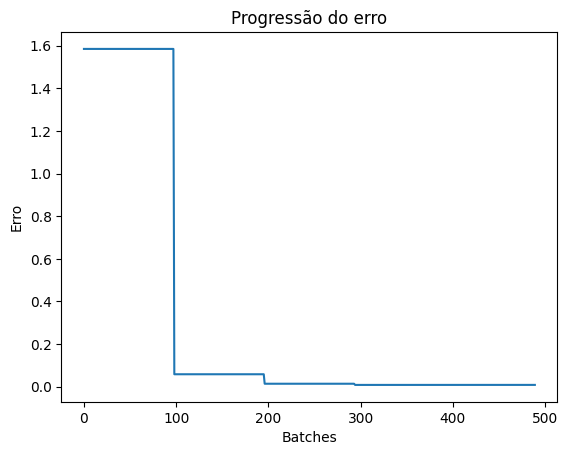

In [ ]:
import matplotlib.pyplot as plt
plt.plot(historico_loss)
plt.title('Progress√£o do erro')
plt.xlabel('Batches')
plt.ylabel('Erro')

In [ ]:
modelo.to_disk("modelo")

# Testes com uma frase

In [ ]:
modelo_carregado = spacy.load('modelo')
modelo_carregado

## Texto positivo

In [ ]:
texto_positivo = base_teste['tweet_text'][21]
texto_positivo

'  fico feliz sabendo q rec√≠proco emocaopositiva'

In [ ]:
previsao = modelo_carregado(texto_positivo)
previsao

  fico feliz sabendo q rec√≠proco emocaopositiva

In [ ]:
previsao.cats

{'POSITIVO': 0.9999998807907104, 'NEGATIVO': 1.3822194944168587e-07}

In [ ]:
texto_positivo = 'eu gosto muito de voc√™'
texto_positivo = preprocessamento(texto_positivo)
texto_positivo

'gosto'

In [ ]:
modelo_carregado(texto_positivo).cats

{'POSITIVO': 0.9999810457229614, 'NEGATIVO': 1.8912447558250278e-05}

## Texto negativo

In [ ]:
base_teste['tweet_text'][4000]

't√¥ triste filme mulan mushu emocaonegativa'

In [ ]:
texto_negativo = base_teste['tweet_text'][4000]
previsao = modelo_carregado(texto_negativo)
previsao.cats

{'POSITIVO': 5.862909446818776e-08, 'NEGATIVO': 1.0}

# Avalia√ß√£o do modelo

In [ ]:
previsoes = []
for texto in base_teste['tweet_text']:
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

In [ ]:
previsoes_final = []
for previsao in previsoes:
  if previsao['POSITIVO'] > previsao['NEGATIVO']:
    previsoes_final.append(1)
  else:
    previsoes_final.append(0)

previsoes_final = np.array(previsoes_final)

In [ ]:
respostas_reais = base_teste['sentiment'].values

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(respostas_reais, previsoes_final)

0.9978

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(respostas_reais, previsoes_final)
cm

array([[2493,    7],
       [   4, 2496]])

<Axes: >

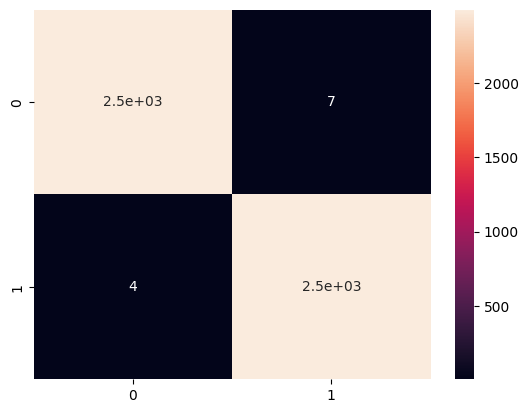

In [ ]:
sns.heatmap(cm, annot=True)